In [2]:
import numpy as np
import cv2  as cv
import matplotlib.pyplot as plt

In [3]:
def getPSNR(I1, I2):
    s1 = cv.absdiff(I1, I2)  #|I1 - I2|
    s1 = np.float64(s1)  # cannot make a square on 8 bits
    s1 = s1 * s1  # |I1 - I2|^2
    sse = s1.sum()  # sum elements per channel
    if sse <= 1e-10:  # sum channels
        return 0  # for small values return zero
    else:
        mse = 1.0 * sse / np.prod(I1.shape)
        psnr = 10.0 * np.log10((255 * 255) / mse)
        return psnr
        
def getSSIM(i1, i2):
    C1 = 6.5025  # only for 8-bit images
    C2 = 58.5225  # only for 8-bit images
    # INITS
    I1 = np.float64(i1)  # cannot calculate on one byte large values
    I2 = np.float64(i2)
    I2_2 = I2 * I2  # I2^2
    I1_2 = I1 * I1  # I1^2
    I1_I2 = I1 * I2  # I1 * I2
    # END INITS
    # PRELIMINARY COMPUTING
    mu1 = cv.GaussianBlur(I1, (11, 11), 1.5)
    mu2 = cv.GaussianBlur(I2, (11, 11), 1.5)
    mu1_2 = mu1 * mu1
    mu2_2 = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_2 = cv.GaussianBlur(I1_2, (11, 11), 1.5)
    sigma1_2 -= mu1_2
    sigma2_2 = cv.GaussianBlur(I2_2, (11, 11), 1.5)
    sigma2_2 -= mu2_2
    sigma12 = cv.GaussianBlur(I1_I2, (11, 11), 1.5)
    sigma12 -= mu1_mu2
    t1 = 2 * mu1_mu2 + C1
    t2 = 2 * sigma12 + C2
    t3 = t1 * t2  # t3 = ((2*mu1_mu2 + C1).*(2*sigma12 + C2))
    t1 = mu1_2 + mu2_2 + C1
    t2 = sigma1_2 + sigma2_2 + C2
    t1 = t1 * t2  # t1 =((mu1_2 + mu2_2 + C1).*(sigma1_2 + sigma2_2 + C2))
    ssim_map = cv.divide(t3, t1)  # ssim_map =  t3./t1;
    ssim = np.mean(ssim_map)  # mssim = average of ssim map
    return ssim

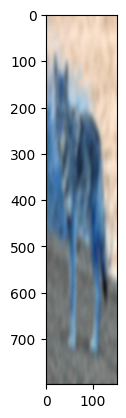

In [4]:
image = cv.imread('image.jpg')
plt.imshow(image)

True

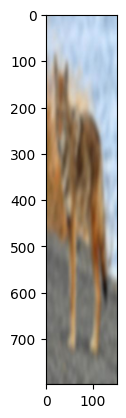

In [5]:
#Преобразуем изображение в rgb
rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(rgb_image)
cv.imwrite("rgb_image.jpg", rgb_image)

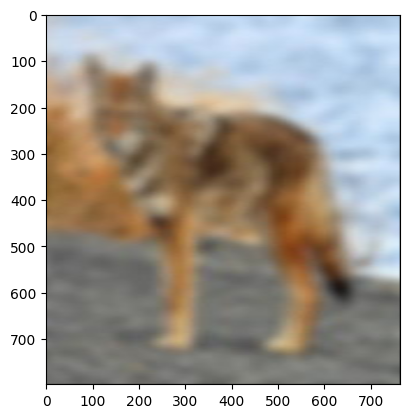

In [6]:
# https://ru.stackoverflow.com/questions/141.55335/python-%D0%B8%D0%B7%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5-%D1%84%D0%BE%D1%80%D0%BC%D1%8B-%D0%BA%D0%B0%D1%80%D1%81.5%D0%B8%D0%BD%D0%BA%D0%B8

# получить форму изображения
(h, w, d) = rgb_image.shape
# сдвиг, примененный к оси x
M = np.float32([ [5, 0, 0],
                [0, 1, 0],
                [0, 0  , 1] ])
# сдвиг, примененный к оси Y
# M = np.float32([ [1,   0, 0],
#                 [0.5, 1, 0],
#                 [0,   0, 1] ])
# применяем перспективное преобразование к изображению
warped = cv.warpPerspective(rgb_image,M,(w * 5,h))
cv.imwrite("warped.jpg", cv.cvtColor(warped, cv.COLOR_RGB2BGR))
plt.imshow(warped)

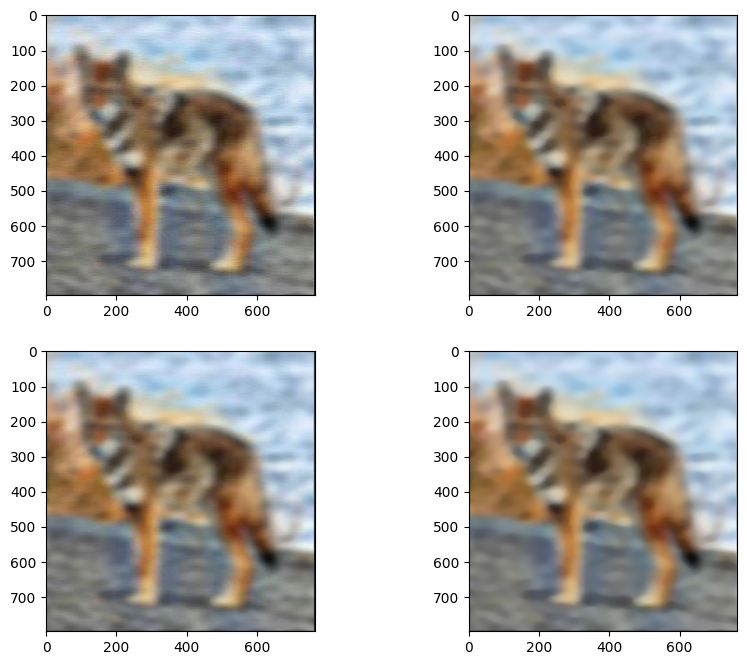

In [7]:
clahe = cv.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))

rgb_result_image = np.empty(np.shape(warped), np.uint8)
rgb_result_image[:, :, 0] = clahe.apply(warped[:, :, 0])
rgb_result_image[:, :, 1] = clahe.apply(warped[:, :, 1])
rgb_result_image[:, :, 2] = clahe.apply(warped[:, :, 2])


sharpen_kernel = np.array([[-1.5,-1.5,-1.5], [-1.5,13,-1.5], [-1.5,-1.5,-1.5]])
sharpen = cv.filter2D(rgb_result_image, -2, sharpen_kernel)
deblurred = cv.fastNlMeansDenoisingColored(sharpen,None,2,2,2,-1)
deblurred_1 = cv.fastNlMeansDenoisingColored(sharpen,None,10, 10, 7, 15)

sharpen_kernel_2 = np.array([[0, -1, 0], [-1, 5, -1], [ 0, -1, 0]])
sharpen_2 = cv.filter2D(rgb_result_image, 0, sharpen_kernel_2)
deblurred_2 = cv.fastNlMeansDenoisingColored(sharpen_2,None,2,2,2,-1)

sharpen_kernel_3 = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen_3 = cv.filter2D(rgb_result_image, -1 , sharpen_kernel_3)
deblurred_3 = cv.fastNlMeansDenoisingColored(sharpen_3,None,10,10,7,21)


gs = plt.GridSpec(2, 2)
plt.figure(figsize=(10, 8))
plt.subplot(gs[0])
plt.imshow(deblurred)
plt.subplot(gs[1])
plt.imshow(deblurred_1)
plt.subplot(gs[2])
plt.imshow(deblurred_2)
plt.subplot(gs[3])
plt.imshow(deblurred_3)

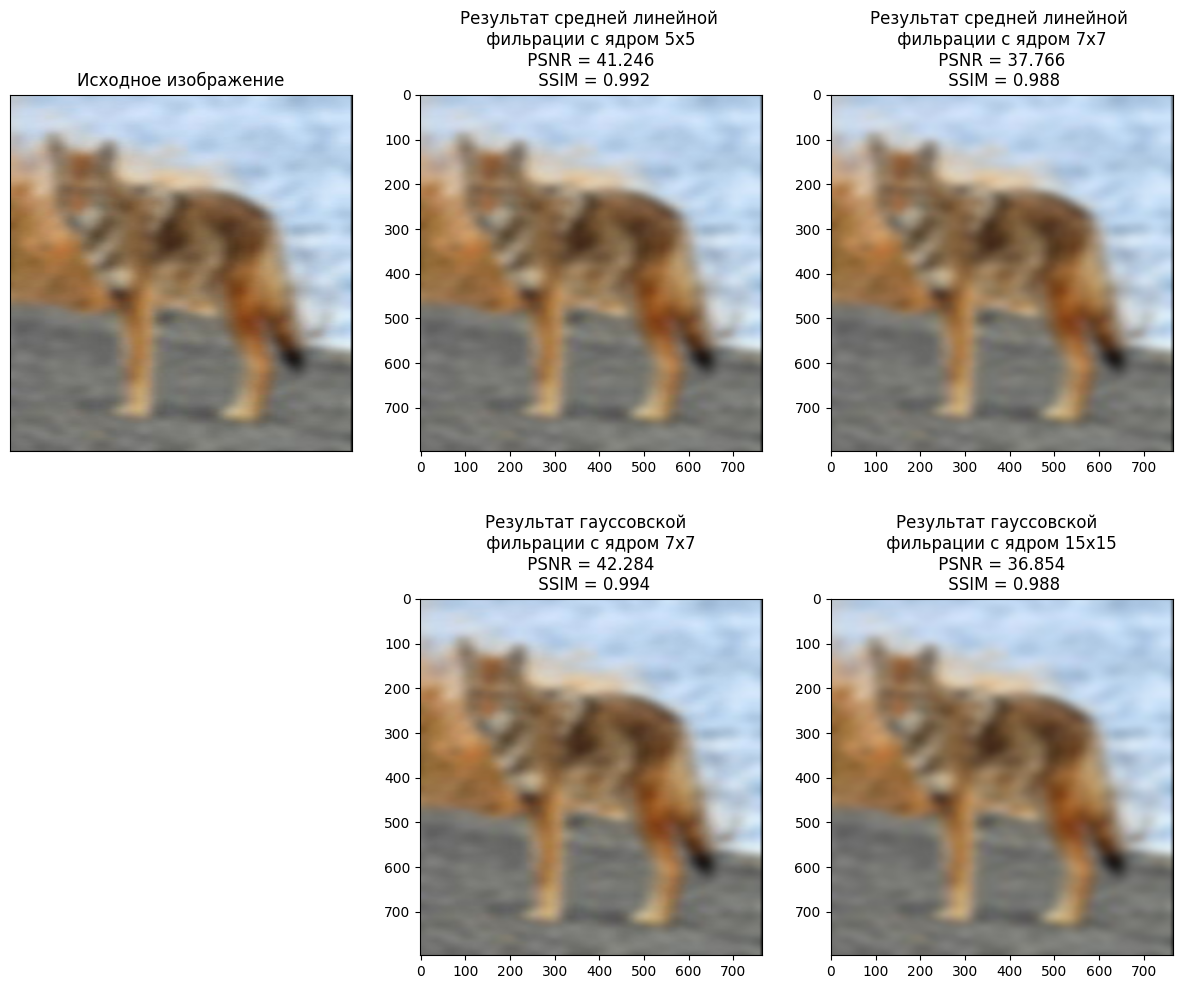

In [8]:
#gray_image1 = cv.cvtColor(warped,cv.COLOR_RGB2GRAY)
gray_image1 = warped
#plt.imshow(gray_image, cmap='gray', vmin = 0, vmax = 255)
kernel55 = np.ones((5, 5), np.float32) / 25
kernel77 = np.ones((7, 7), np.float32) / 49
filtered_image1 = cv.filter2D(gray_image1, -1, kernel55)
filtered_image2 = cv.filter2D(gray_image1, -2, kernel77)
filtered_image3 = cv.GaussianBlur(gray_image1, (7, 7), 0)
filtered_image4 = cv.GaussianBlur(gray_image1, (15, 15), 0)

# вывод
gs = plt.GridSpec(2, 3)
plt.figure(figsize=(15, 12))
plt.subplot(gs[0])
plt.xticks([]), plt.yticks([])
plt.title('Исходное изображение')
plt.imshow(gray_image1, cmap='gray')
plt.subplot(gs[1])
plt.title(f'Результат средней линейной \n фильрации с ядром 5х5 \n '
          f'PSNR = {getPSNR(gray_image1, filtered_image1):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image1):.3f}')
plt.imshow(filtered_image1, 'gray')
plt.subplot(gs[2])
plt.title(f'Результат средней линейной \n фильрации с ядром 7х7 \n '
          f'PSNR = {getPSNR(gray_image1, filtered_image2):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image2):.3f}')
plt.imshow(filtered_image2, 'gray')
plt.subplot(gs[4])
plt.title(f'Результат гауссовской  \n фильрации с ядром 7х7 \n '
          f'PSNR = {getPSNR(gray_image1, filtered_image3):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image3):.3f}')
plt.imshow(filtered_image3, 'gray')
plt.subplot(gs[5])
plt.title(f'Результат гауссовской  \n фильрации с ядром 15х15 \n '
          f'PSNR = {getPSNR(gray_image1, filtered_image4):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image4):.3f}')
plt.imshow(filtered_image4, 'gray')
plt.show()


In [9]:
# Преобразование в двоичный формат
_,thresh = cv.threshold(gray_image,30,255,cv.THRESH_BINARY)

#Поиск контyра 
contours,hierarchy = cv.findContours(thresh,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
cnt = contours[0]

#Кадрирование
x,y,w,h= cv.boundingRect(cnt)
croped_image = warped[y:y+h,x:x+w]
cv.imwrite("croped_image.jpg", croped_image)

plt.imshow(croped_image)

NameError: name 'gray_image' is not defined

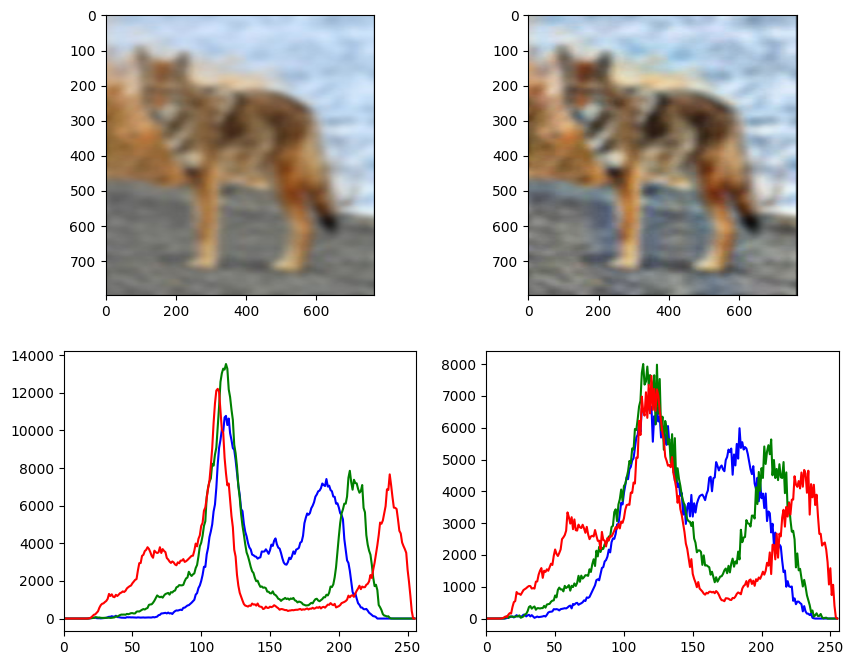

In [ ]:
croped_image

histSize = [256]
range = [0, 256]

def plot_rgb_hist(image, histSize, range):
    histSize = [256]
    range = [0, 256]
    for i, col in enumerate(['b', 'g', 'r']):
        hist = cv.calcHist([image], [i], None, histSize, range)
        plt.plot(hist, color=col)
        plt.xlim(range)

clahe = cv.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))

rgb_result_image = np.empty(np.shape(croped_image), np.uint8)
rgb_result_image[:, :, 0] = clahe.apply(croped_image[:, :, 0])
rgb_result_image[:, :, 1] = clahe.apply(croped_image[:, :, 1])
rgb_result_image[:, :, 2] = clahe.apply(croped_image[:, :, 2])


gs = plt.GridSpec(2, 2)
plt.figure(figsize=(10, 8))
plt.subplot(gs[0])
plt.imshow(croped_image)
plt.subplot(gs[1])
plt.imshow(rgb_result_image)
plt.subplot(gs[2])
plot_rgb_hist(croped_image, histSize, range)
plt.subplot(gs[3])
plot_rgb_hist(rgb_result_image, histSize, range)

cv.imwrite("rgb_result_image.jpg", rgb_result_image)
plt.show()


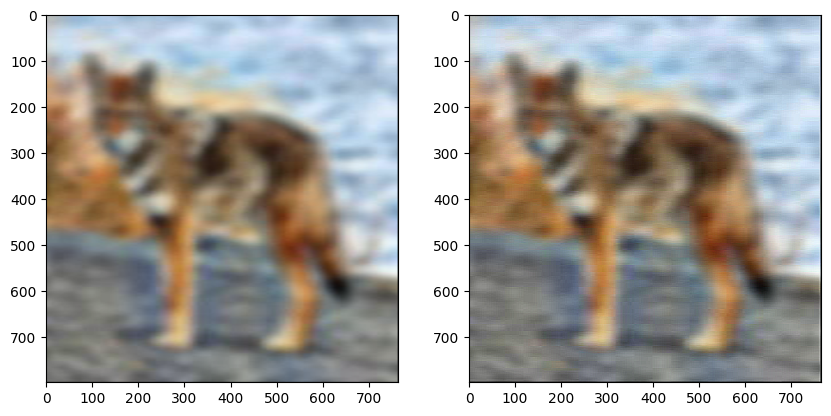

True

In [ ]:
kernel1 = np.asarray([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
#kernel1 = np.asarray([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
filtered_image = cv.filter2D(rgb_result_image, -1, kernel1)

gs = plt.GridSpec(1, 2)
plt.figure(figsize=(10, 8))
plt.subplot(gs[0])
plt.imshow(rgb_result_image)
plt.subplot(gs[1])
plt.imshow(filtered_image)

plt.show()
cv.imwrite("result_image.jpg", filtered_image)
